# Generative Basic Assignment (2024/03/13)
#### Questions(1,2) are below
#### Contact -> toa2413@naver.com / 송인혁(투빅스20기)

In [92]:
import datetime
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Q1. Encoder/Decoder Implementation
    Show me your visualizations(MNIST images) using a VAE model made up of your own 'Encoder2/Decoder2'
    I can see your visualizations at the last part of this code file (Assignment 1 ; Visualization)
    
***You can refer to the examples right under this markdown, please make your own Encoder (Class name; Encoder2/Decoder2)***

In [94]:
# # You can freely choose one of architectures you want that looks promising
# class Encoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
#         super(Encoder, self).__init__()
#         self.input1 = nn.Linear(input_dim, hidden_dim)
#         self.input2 = nn.Linear(hidden_dim, hidden_dim2)
#         self.mean = nn.Linear(hidden_dim2, latent_dim)
#         self.var = nn.Linear (hidden_dim2, latent_dim)

#         self.LeakyReLU = nn.LeakyReLU(0.2)
#         self.training = True

#     def forward(self, x):
#         h_ = self.LeakyReLU(self.input1(x))
#         h_ = self.LeakyReLU(self.input2(h_))
#         mean = self.mean(h_)
#         log_var = self.var(h_)
#         return mean, log_var

In [95]:
class Encoder2(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Encoder2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        self.fc3_mean = nn.Linear(hidden_dim2, latent_dim)
        self.fc3_log_var = nn.Linear(hidden_dim2, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc3_mean(x)
        log_var = self.fc3_log_var(x)
        return mean, log_var

In [96]:
# class Decoder(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, hidden_dim2, output_dim):
#         super(Decoder, self).__init__()
#         self.hidden1 = nn.Linear(latent_dim, hidden_dim2)
#         self.hidden2 = nn.Linear(hidden_dim2, hidden_dim)
#         self.output = nn.Linear(hidden_dim, output_dim)
#         self.LeakyReLU = nn.LeakyReLU(0.2)

#     def forward(self, x):
#         h = self.LeakyReLU(self.hidden1(x))
#         h = self.LeakyReLU(self.hidden2(h))
#         x_hat = torch.sigmoid(self.output(h))
#         return x_hat

In [97]:
class Decoder2(nn.Module):
    def __init__(self, latent_dim, hidden_dim2, hidden_dim, output_dim):
        super(Decoder2, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        x_reconstructed = torch.sigmoid(self.fc3(z))
        return x_reconstructed

In [98]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    # Think about why you need reparameterization trick (Hint; backpropagation)
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [99]:
# Any modifications are allowed depending on your own Encoder2/Decoder2
# -----------------------------------
x_dim  = 784
hidden_dim = 512
hidden_dim2 = 256
latent_dim = 20
epochs = 30
batch_size = 100
# -----------------------------------



# encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
encoder = Encoder2(x_dim, hidden_dim, hidden_dim2, latent_dim)

# decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, output_dim = x_dim)
decoder = Decoder2(latent_dim, hidden_dim2, hidden_dim, x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Q2. (Optional Assignment)
    Refering to Beta-VAE(https://openreview.net/forum?id=Sy2fzU9gl), give any kind of manipulations on pre-made loss function, and visualize your samples.
    It would be nice to see whether the fidelity of sample data is improved or not! Also guess why.
***Warning)  you don't have to take all the contents of this paper! Look carefully at the Equation (4)***

In [100]:
# (Optional Assignment)
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Think about how to calculate KLDivergence in closed form (Hint; assumptions for Gaussian), please refer to the following links
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    # closed form: KLD = 0.5 * torch.sum(log_var.exp() + mean.pow(2) - 1 - log_var)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [101]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))

    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [102]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())

In [103]:
# Trackning the process
# If you have difficulty on installing 'tqdm', modifications are allowed. Not necessary
from tqdm.auto import tqdm

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")


  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 544.543711
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 196.268281
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 178.954316
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 157.692998
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 142.347383
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 131.706855
======> Epoch: 0 Average loss: 166.6778


Train Epoch: 1 [0/60000 (0%)]	 Loss: 129.903281
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 121.179434
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 115.693877
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 119.775078
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 121.285186
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 112.557969
======> Epoch: 1 Average loss: 122.4145


Train Epoch: 2 [0/60000 (0%)]	 Loss: 120.023594
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 114.764326
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 112.614336
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 114.050469
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 111.663525
Train Epoch: 2 [50000/60000 (8

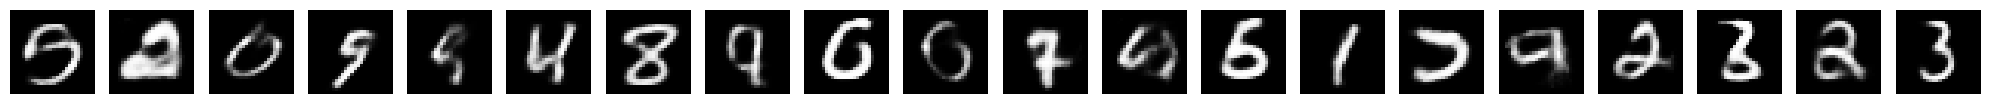

In [104]:
# After training decoder, begin visualize what comes after decoder given input z
def visualize(decoder,z):
    x_sample = decoder(z).view(20,28,28).cpu().detach().numpy()
    fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sample[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

z_sample = torch.randn(20,20).to(device)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)


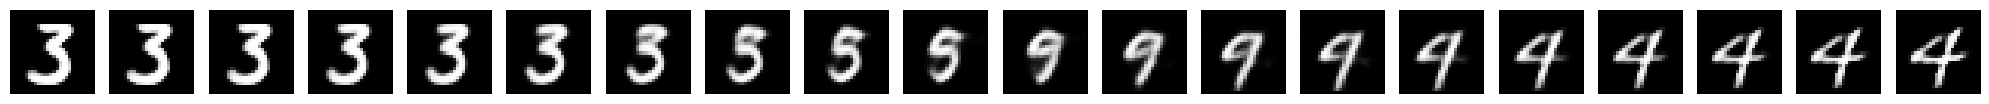

In [105]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(20)
# Make copies
z = z.repeat(20,1).to(device)

# Interpolation in latent space z
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)

## Answer(Q2; Optional) : Please write any codes or statements below this space
